In [1]:
%matplotlib inline
%precision 16
import numpy
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt

## Test for backward euler method

Set variables related to change of variables: $(S,v)\rightarrow(\xi, \eta)$

In [2]:
K     = 1200.0
S_max = 3000.0
S_min = 400.0
v_max = 0.04
v_min = 0.0
alpha = S_max - S_min
beta  = v_max - v_min
c1    = numpy.arcsinh( (S_max - K)/alpha )
print c1
c2    = numpy.arcsinh( (S_min - K)/alpha )
print c2
d1    = numpy.arcsinh( v_max/beta )
print d1

0.646353395986
-0.303033092725
0.88137358702


Set coefficients of heston pde

In [3]:
rho   = 0.5
sigma = 0.01
r     = 0.01
q     = 0
kappa = 0.02
theta = 0.04

Set grid

In [4]:
t_final = 0.125
N = 10
M = 10
L = 10

xi  = numpy.linspace(0, 1, N+2) 
eta = numpy.linspace(0, 1, M+2)
t   = numpy.linspace(0, t_final, L)

# Interior points
xi  =  xi[1:-1] 
eta = eta[1:-1]

delta_xi  =  xi[1] -  xi[0]
delta_eta = eta[1] - eta[0]
delta_t   =   t[1] -   t[0]

Common function that needs during entire run time

In [5]:
S         = lambda xi: K + alpha * numpy.sinh( c1*xi + c2*(1-xi) )
dSdxi     = lambda xi: alpha * numpy.cosh( c1*xi + c2*(1-xi) ) * (c1 - c2)
d2Sdxi2   = lambda xi: alpha * numpy.sinh( c1*xi + c2*(1-xi) ) * (c1 - c2)**2

v         = lambda eta: beta*numpy.sinh( d1*eta )
dvdeta    = lambda eta: numpy.cosh( d1*eta ) * d1 * beta
d2vdeta2  = lambda eta: numpy.cosh( d1*eta ) * d1**2 * beta

Allocate solution vector U

In [6]:
U = numpy.empty([N+2, M+2])
U_interior_old = numpy.zeros(N*M)
U_interior_new = numpy.zeros(N*M)

Set function to construct matrix A

In [7]:
a = lambda i,j: delta_t*rho*sigma/(4.0*delta_xi*delta_eta)*v(eta[j])*S(xi[i])/(dSdxi(xi[i]) * dvdeta(eta[j]))
b = lambda i,j: sigma**2 * delta_t/(2.0*delta_eta**2)*v(eta[j])/dvdeta(eta[i])**2 - \
                delta_t/(2.0*delta_eta)*(kappa*(theta-v(eta[j]))/dvdeta(eta[j]) - 0.5*sigma**2*v(eta[j])*d2vdeta2(eta[j])/dvdeta(eta[j])**3)
c = lambda i,j: delta_t/delta_xi**2*v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 - \
                delta_t/(2.0*delta_xi)*((r-q)*S(xi[i])/dSdxi(xi[i]) - 0.5*v(eta[j])*S(xi[i])**2*d2Sdxi2(xi[i])/dSdxi(xi[i])**3)
d = lambda i,j: 1 + r*delta_t + delta_t/delta_xi**2 * v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 + sigma**2*delta_t/delta_eta**2*v(eta[j])/dvdeta(eta[i])**2
e = lambda i,j: delta_t/delta_xi**2*v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 + \
                delta_t/(2*delta_xi)*((r-q)*S(xi[i])/dSdxi(xi[i]) - 0.5*v(eta[j])*S(xi[i])**2*d2Sdxi2(xi[i])/dSdxi(xi[i])**3)
f = lambda i,j: sigma**2*delta_t/(2*delta_eta**2)*v(eta[j])/dvdeta(eta[i])**2 + \
                delta_t/(2.0*delta_eta)*(kappa*(theta - v(eta[j]))/dvdeta(eta[j]) - 0.5*sigma**2*v(eta[j])*d2vdeta2(eta[j])/dvdeta(eta[j])**3)

Allocate memory

In [8]:
A = numpy.zeros([M*N, M*N])
rhs = numpy.zeros(N*M)

Initialize U_interior vector

In [9]:
for i in range(N):
    U_interior_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * S(xi[i]) - K , 0.0)
# Add for test
U_init = numpy.copy(U_interior_old)

In [10]:
print U_interior_old[-1]

1533.43990901


Variables for boundary condition

In [11]:
# For bottom bc xi = 0 
_l = 2.0 * dSdxi(xi[0]) / ( dSdxi(xi[0]) + 0.5 * delta_xi * d2Sdxi2(xi[0]) )
l_ = - ( dSdxi(xi[0]) - 0.5* delta_xi * d2Sdxi2(xi[0]) ) / ( dSdxi(xi[0]) + 0.5* delta_xi* d2Sdxi2(xi[0]) )

# For upper bc xi = 1
_r = - ( dSdxi(xi[-1]) + 0.5 * delta_xi * d2Sdxi2(xi[-1]) ) / ( dSdxi(xi[-1]) - 0.5 * delta_xi * d2Sdxi2(xi[-1]) )
r_ = 2.0 * dSdxi(xi[-1]) / ( dSdxi(xi[-1]) - 0.5 * delta_xi * d2Sdxi2(xi[-1]) )

Construct matrix A

In [12]:
for irow in range(M*N):
    # U_hat[irow] == U_interior[i,j]
    i = irow/M
    j = numpy.mod(irow, N)
    if( i == 0 ):
        if (j == 0):
            A[irow, irow + M]     = -e(i,j)
            A[irow, irow + M + 1] = -a(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
        elif (j == M-1):
            A[irow, irow + M - 1] =  a(i,j) - a(i,j)*l_
            A[irow, irow + M]     = -e(i,j) - c(i,j)*l_
            A[irow, irow - 1]     = -b(i,j) - a(i,j)*_l
            A[irow, irow]         =  d(i,j) - c(i,j)*_l
            rhs[irow] = -a(i,j)*S(0) + f(i,j)*S(xi[i]) + a(i,j)*S(xi[i+1])
        else: # Add term for bc condition
            A[irow, irow + M - 1] =  a(i,j) - a(i,j)*l_
            A[irow, irow + M]     = -e(i,j) - c(i,j)*l_
            A[irow, irow + M + 1] = -a(i,j) + a(i,j)*l_
            A[irow, irow - 1]     = -b(i,j) - a(i,j)*_l
            A[irow, irow]         =  d(i,j) - c(i,j)*_l
            A[irow, irow + 1]     = -f(i,j) + a(i,j)*_l
    elif (i == N-1):
        if (j == 0):
            A[irow, irow - M ]    = -c(i,j) - e(i,j)*_r
            A[irow, irow - M + 1] =  a(i,j) - a(i,j)*_r
            A[irow, irow]         =  d(i,j) - e(i,j)*r_
            A[irow, irow + 1]     = -f(i,j) - a(i,j)*r_
        elif (j == M-1):
            A[irow, irow - M - 1] = -a(i,j) + a(i,j)*_r
            A[irow, irow - M ]    = -c(i,j) - e(i,j)*_r
            A[irow, irow - 1]     = -b(i,j) + a(i,j)*r_
            A[irow, irow]         =  d(i,j) - e(i,j)*r_
            rhs[irow] = -a(i,j)*S(xi[i-1]) + f(i,j)*S(xi[i]) + a(i,j)*S(1)
        else:
            A[irow, irow - M - 1] = -a(i,j) + a(i,j)*_r
            A[irow, irow - M ]    = -c(i,j) - e(i,j)*_r
            A[irow, irow - M + 1] =  a(i,j) - a(i,j)*_r
            A[irow, irow - 1]     = -b(i,j) + a(i,j)*r_
            A[irow, irow]         =  d(i,j) - e(i,j)*r_
            A[irow, irow + 1]     = -f(i,j) - a(i,j)*r_
    else:
        if (j == 0):   
            A[irow, irow - M ]    = -e(i,j)
            A[irow, irow - M + 1] = -a(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            A[irow, irow + M]     = -c(i,j)
            A[irow, irow + M + 1] =  a(i,j)
        elif (j == M-1):
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + M - 1] =  a(i,j)
            A[irow, irow + M]     = -e(i,j)
            rhs[irow] = -a(i,j)*S(xi[i-1]) + f(i,j)*S(xi[i]) + a(i,j)*S(xi[i+1])
        else:
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - M + 1] =  a(i,j)
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            A[irow, irow + M - 1] =  a(i,j)
            A[irow, irow + M]     = -e(i,j)
            A[irow, irow + M + 1] = -a(i,j)

1.05167196732
-0.0487823604393


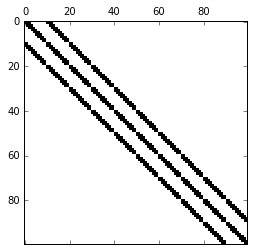

In [13]:
fig = plt.figure()
plt.spy(A[0:200, 0:200])
print numpy.max(A)
print numpy.min(A)
# E, X = numpy.meshgrid(numpy.linspace(0,1,N*M), numpy.linspace(0,1,N*M))
# # Plot solution
# fig = plt.figure()
# axes = fig.add_subplot(1, 1, 1)
# sol_plot = axes.pcolor(E, X, A, cmap=plt.get_cmap('RdBu_r'))
# axes.set_title("Element of A")
# axes.set_xlabel("eta")
# axes.set_ylabel("xi")
# cbar = fig.colorbar(sol_plot, ax=axes)

Do backward Euler, $AU^{n+1} = U^{n} + rhs$

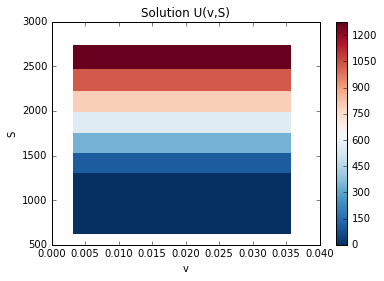

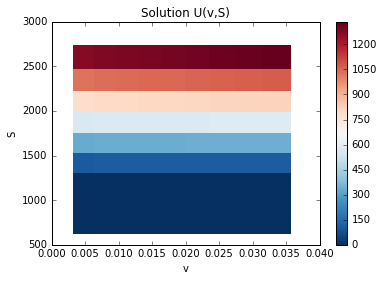

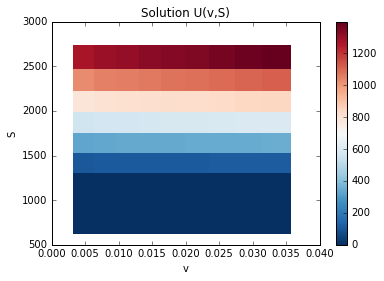

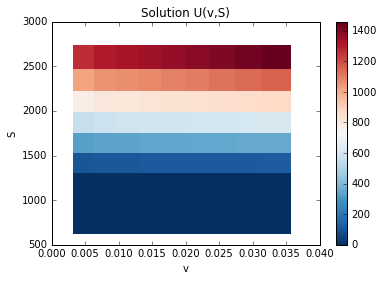

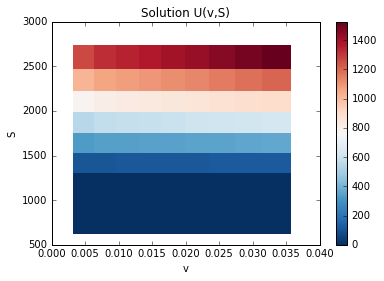

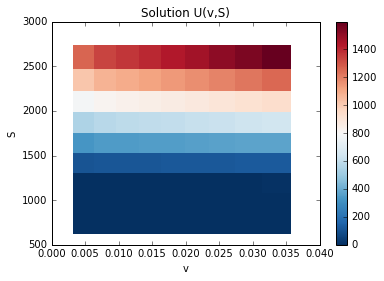

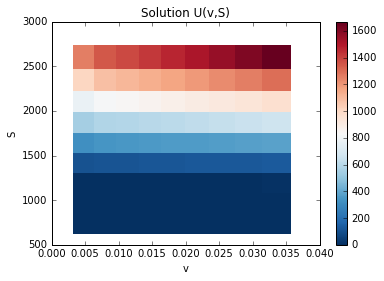

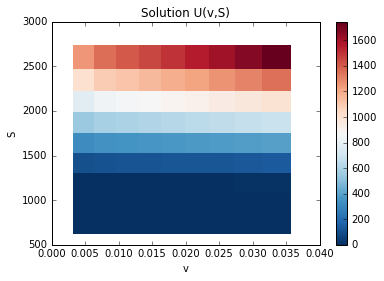

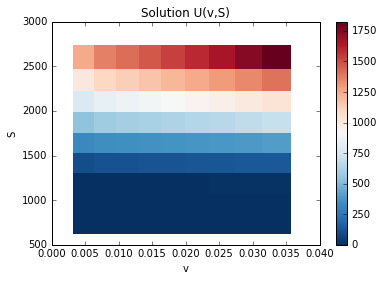

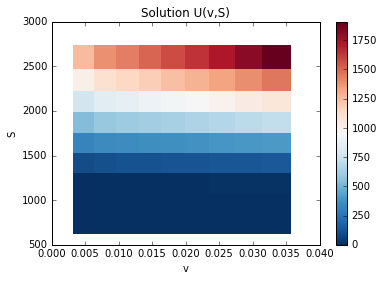

In [14]:
for timestep in t:
    E, X = numpy.meshgrid(v(eta), S(xi))
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    sol_plot = axes.pcolor(E, X, numpy.reshape(U_interior_old, [M, N]), cmap=plt.get_cmap('RdBu_r'))
    axes.set_title("Solution U(v,S)")
    axes.set_xlabel("v")
    axes.set_ylabel("S")
    cbar = fig.colorbar(sol_plot, ax=axes)

    # For each time step, we need to first solve the pde for lower boundary condition
    # lower bc
    # Construct matrix A_bc for boundary condition
    alpha_bc = numpy.multiply( (r-q) * delta_t/(2.0 * delta_xi), numpy.divide(S(xi), dSdxi(xi)) ) # vector
    beta_bc = kappa*theta*delta_t / ( 2*delta_eta*dvdeta(0) )

    maindiag = numpy.ones(N)*(1+r*delta_t)
    maindiag[0] += alpha_bc[0] * _l
    maindiag[-1] += alpha_bc[-1] * r_

    upperdiag = -alpha_bc
    upperdiag[0] += alpha_bc[0] * l_

    lowerdiag = numpy.zeros(N)
    lowerdiag[:-1] = alpha_bc[1:]
    lowerdiag[-2] -= alpha_bc[-1]*_r

    A_bc = sparse.spdiags([lowerdiag, maindiag, upperdiag], [-1, 0, 1], N, N).tocsr()

    #initialize U_bc vector
    U_bc = numpy.zeros(N)
    U_bc = numpy.maximum(0, S(xi) - K)

    #rhs (Need U vector in previous time step)
    rhs_bc = numpy.zeros(N)
    for i in range(len(rhs_bc)):
        rhs_bc[i] = (-3.0 * beta_bc + 1)*U_bc[i] + 4.0*U_interior_old[i*M] - beta*U_interior_old[i*M]
    U_bc = linalg.spsolve(A_bc, rhs_bc)

    # After solve the lower boundary condition, update the corresponding rhs
    for i in range(N):
        if i==0:
            rhs[i*M] = a(i,0)*(U_bc[i+1]*_l + U_bc[i]*l_) + b(i,0) * U_bc[i] - a(i,0) * U_bc[i+1]
        elif i==N-1:
            rhs[i*M] = -a(i,0)*(U_bc[i-1]*r_ + U_bc[i]*_r) + a(i,0) * U_bc[i-1] + b(i,0) * U_bc[i]
        else:
            rhs[i*M] = a(i,0) * U_bc[i-1] + b(i,0) * U_bc[i] - a(i,0) * U_bc[i+1]

    U_interior_new = numpy.linalg.solve(A, U_interior_old + rhs)
    U_interior_old = numpy.copy(U_interior_new)
    

Reshape the U vector

In [15]:
U_interior = numpy.reshape(U_interior_new, [M, N])

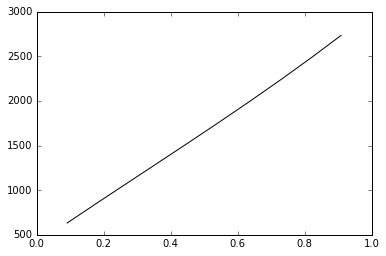

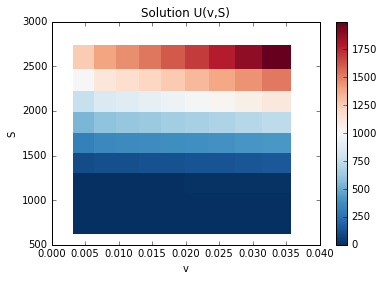

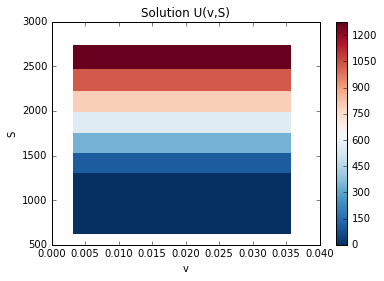

2700.69205489


In [16]:
E, X = numpy.meshgrid(v(eta), S(xi))
#E, X = numpy.meshgrid(eta, xi)
fig = plt.figure()
# Plot right boundary condition
axes = fig.add_subplot(1, 1, 1)
axes.plot(xi, S(xi), 'k-')
# Plot solution
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, U_interior, cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)
# Plot initial data
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, numpy.reshape(U_init, [M, N]), cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)
plt.show()

print U_interior[-1,-1]